In [1]:
import time
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
import seaborn as sns
# fix random seed for reproducibility
np.random.seed(7)

# Pretratamiento para LSTM/GRU.
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# keras LSTM.
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, GRU, LSTM, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint

# keras exportación del modelo.
from keras.models import model_from_json

ROOT = "C:/Users/"

# Modelo con Redes Neuronales Recursivas - LSTM

Este cuaderno va a tratar de aprovechar las Redes Recursivas, siendo este tipo específico capaz de transmitir información entre sus capas, siendo mucho más eficientes para predecir patrones entre series de datos. Si bien estas también dependen de datos coherentes historicamente, son mucho más potentes a la hora de encontrar patrones complejos que cualquier otro método y es capaz de absorver bien el impacto del covid.

Los siguientes enlaces contienen unas guías que explican los algoritmos:

- https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
- https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- Videotutorial explicativo de código - https://www.youtube.com/watch?v=tepxdcepTbY
- Guía para el optimizador - https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594

Otros enlaces interesantes:

- https://www.tensorflow.org/tutorials/structured_data/time_series
- https://www.tensorflow.org/guide/keras/rnn

In [54]:
# Desplaza los valores de un array "n" casillas.
def rotate(array, n = 1):
    return array[n:] + array[:n]

# Convierte un array de valores en una matriz dataset.
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1): # Se seleccionan para estudiar los datos en función del valor del lookback.
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Función para el split.
def divide(df, proporcion = 0.75):
    corte = round(len(df)*proporcion)
    train = df[:corte]
    test = df[corte:]
    return train, test

# Métricas de performance.
def forecast_accuracy(forecast, actual):
    #=============================================================== AÑADIDO PARA DIFERENTES ARRAY
    if (len(forecast) != len(actual)):
        if (len(forecast) < len(actual)):
            actual = actual[:len(forecast)]
        else:
            forecast = forecast[:len(actual)]
    #===============================================================
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual) / actual) # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]  # corr
    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis = 1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis = 1)
    minmax = 1 - np.mean(mins / maxs)           # minmax
    acf1 = acf(forecast - actual)[1]            # autocorrelación del error, primer lag
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 'corr':corr, 'minmax':minmax})

# Convierte el array de series en una matriz donde cada dato n_out viene explicado por los n_in datos anteriores.
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t - n, ... t - 1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t + 1, ... t + n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg

# Crea el modelo que se va a usar.
# Las variables no declaradas con valores preestablecidos aquí, mantendrán esos valores en caso de no explicitarse otro en la llamada a la función.
def creador_de_modelos(train_X, loss = 'mean_squared_error', optimizer = 'adamax', init = 'glorot_uniform', fast = True):
    model = Sequential()
    if (fast): # Escoge entre las capas GRU, más rápidas pero peores predictoras.
        model.add(GRU(64, return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2])))
        # Apilando una segunda capa ->
        # return_sequences = True permite entregar la información íntegra a la siguiente capa de manera que mejora la transmisión.
        model.add(GRU(64, return_sequences = True, activation = 'relu'))
        # Apilando una tercera capa ->
        # La última capa no debe tener return_sequences ya que este mantendría las 3D, y el modelo debe devolver 2D.
        model.add(GRU(32, activation = 'relu'))
    else: # O las LSTM, mejores pero más lentas.
        model.add(LSTM(64, return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2])))
        model.add(LSTM(64, return_sequences = True, activation = 'relu'))
        model.add(LSTM(32, activation = 'relu'))
    
    model.add(Dense(32, activation = 'relu'))
    #model.add(Dense(32, activation = 'relu'))
    #model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1)) # Una capa de salida para el único valor de la regresión.
    model.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])
    return model

# =============================================================

### Predicción del modelo mediante aprendizaje supervisado, empleando únicamente el Time Series

El primer planteamiento de solución para el problema va a ser el estudio del Time Series con unicamente los propios datos numéricos del modelo.

Código extraído del cuaderno del estudio de datos.

In [84]:
# los tres dataset
df_clientes = pd.read_csv(ROOT + ".csv", delimiter = ',')
df_dim_pedidos = pd.read_csv(ROOT + ".csv", delimiter = ',')
df_pedidos = pd.read_csv(ROOT + ".csv", delimiter = ',')
df_clientes = df_clientes.dropna()
df_dim_pedidos = df_dim_pedidos.dropna()
df_pedidos = df_pedidos.dropna()

# selecciona el id y la cantidad de pedidos en tabla auxiliar
df_aux = pd.DataFrame()
df_aux['cantidad'] = df_pedidos.groupby('digit_digit_sm_idpedido')['digit_digit_sm_cantidad'].sum()
df_aux = df_aux.reset_index() # groupby convierte la variable clave en index, por lo que hay que desconvertir

# crea un dataframe para unirlo todo
df = pd.DataFrame()
df['timestamp'] = pd.to_datetime(df_dim_pedidos['digit_digit_sm_fechapedido']) # extrae fechas
df = df[df['timestamp'] > '2015-01-01'] # a partir del año del comportamiento actual
#df = df[df['timestamp'] > '2012-01-01'] # a partir del año incluyendo la crisis del 2008
#df = df[df['timestamp'] < '2021-06-01'] # omitiendo los picos de ventas post-covid
df['id_pedido'] = df_dim_pedidos['digit_digit_sm_idpedido'] # extrae id para añadir la informacion del pedido
df = df.join(df_aux.set_index('digit_digit_sm_idpedido'), on = 'id_pedido') # añade informacion de pedido
df = df.drop(['id_pedido'], axis = 1) # elimina la columna auxiliar de los pedidos
df = df.sort_values(by = 'timestamp', ascending = True) # ordena segun el timestamp
df['week'] = df['timestamp'].dt.isocalendar().week # una columna con la semana del año
df['year'] = df['timestamp'].dt.year # una columna por año
df = df.set_index(['week', 'year']) # establece semanas y años de index para agrupar segun ellos
df['cantidad'] = df.groupby(['week', 'year'])['cantidad'].sum() # agrupa los pedidos que se produjeron la misma semana del año
df = df[~ df.index.duplicated(keep = 'first')] # elimina las replicas que se han producido en la agrupacion anterior
df = df.reset_index().set_index(['timestamp']) # cambia timestamp de index
df = df.drop(['week', 'year'], axis = 1) # elimina las columnas innecesarias
df['cantidad'] = df['cantidad'].rolling(1, center = True, closed = 'both').mean() # suavizado mediante Moving Average
# elimina nan
print(df.shape)
df = df.dropna()
print(df.shape)

# elimina negativos y ceros para poder aplicar seasonal
df = df[df['cantidad'] > 0]
df

(362, 1)
(362, 1)


,cantidad
timestamp,
2015-01-02,4665.0
2015-01-06,9749.0
2015-01-12,13518.0
2015-01-19,12178.5
2015-01-26,11241.5
...,...
2021-11-01,10442.0
2021-11-10,6107.0
2021-12-01,16609.5


Hay que exclarecer que la variable **look_back** indica el número de datos previos que serán tenidos en cuenta para explicar el futuro inmediato. Los datos sirven para generar la base de outcomes o Y, que consiste en los datos del modelo en plano, y los predictores o X, cuyas columnas representan tantos outcomes anteriores, como valor de **look_back** se hubiera explicitado previamente. Esto último significa que este dataset X está compuesto de datos previos que servirán para explicar los Y igual que cualquier modelo normal lo haría.

In [4]:
look_back = 6

Para poder trabajar con modelos neuronales los datos de trabajo deben convertirse en números, se tienen que normalizar y hacer que todos sean el mismo tipo de variable.

In [5]:
values = df.values
# Garantiza que todos los datos estén en flotante.
values = values.astype('float32')
# Normalización de los datos para poder ser procesados por una red neuronal.
scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values[:, 0].reshape(len(values), 1)) # Se va a escalar únicamente los datos útiles.
# Creación de la matriz de lags previos como predictores.
reframed = series_to_supervised(scaled, n_in = look_back).values

Cuando se realiza un split, no se deben desordenar los datos para mantener la coherencia de las predicciones en la red neuronal. La función **series_to_supervised** añadió como variables predictoras los datos anteriores al dato que se quiere predecir. El reshape se realiza para poder ser empleado por la red neuronal.

In [6]:
# Divide los datos en train y test.
train, test = divide(reframed, proporcion = 0.95)
# Separa el dataset entre datos de predicción X y datos reales Y.
trainX, trainY = train[:, :-1], train[:, -1]
testX, testY = test[:, :-1], test[:, -1]
# Cambio a formato ideal (3D) para la red neuronal.
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(338, 1, 6) (338,)
(18, 1, 6) (18,)


A continuación se va a construir el modelo preestablecido. Hay que tener en cuenta que de base, el modelo va a ser programado en GRU, que es una versión recurrente más rápida pero menos efectiva que LSTM. Esto siempre se puede cambiar haciendo que **fast = False**.

- Para mejorar el performance se podría optar por usar redes recurrentes más densas en las primeras capas. También hacer capas densas más grandes al principio o más capas densas.

- Si bien para estudiar la construcción de la red es mejor un estudio del error más potente como MSE, para evitar el overfitting en la validación del modelo definitivo, se recomienda usar el MAE (loss = 'mae'). El concepto de overfitting será explicado en el entrenamiento del modelo.

In [7]:
model = creador_de_modelos(trainX, loss = 'mae', fast = True)

Se construyen manualmente dos modelos similares al original pero con cambios distintivos que permitan revelar el impacto en el comportamiento dela predicción final;

In [8]:
# Modelo de prueba con dropouts.
model_dropout = Sequential()
model_dropout.add(GRU(64, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
model_dropout.add(GRU(64, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True, activation = 'relu'))
model_dropout.add(GRU(32, dropout = 0.2, recurrent_dropout = 0.2, activation = 'relu'))
model_dropout.add(Dense(32, activation = 'relu'))
model_dropout.add(Dense(1)) # Una capa de salida para el único valor de la regresión.
model_dropout.compile(loss = 'mae', optimizer = 'adamax', metrics = ['accuracy'])
# Modelo de prueba con capas bidireccionales añadidas a las genéricas.
model_bidirectional = Sequential()
model_bidirectional.add(Bidirectional(GRU(64, return_sequences = True), input_shape = (trainX.shape[1], trainX.shape[2])))
model_bidirectional.add(Bidirectional(GRU(64, return_sequences = True, activation = 'relu')))
model_bidirectional.add(Bidirectional(GRU(32, activation = 'relu')))
model_bidirectional.add(Dense(32, activation = 'relu'))
model_bidirectional.add(Dense(1)) # Una capa de salida para el único valor de la regresión.
model_bidirectional.compile(loss = 'mae', optimizer = 'adamax', metrics = ['accuracy'])

A continuación se propone un fragmento de código que puede ser activado en cualquier momento para realizar una optimización de hiperparámetros. Para la creación de este modelo no se ha empleado debido a lo que este tardaría.

Se proponen para su uso dos callbacks, que son operaciones para mejorar el entrenamiento mediante ciertas estrategias. El primero se trata del **early stop**, que sirve para detener las iteraciones de los epochs cuando el algoritmo percibe cambios mínimos de performance. Esto reduciría drásticamente el tiempo de entrenamiento.

In [9]:
earlystopper = EarlyStopping(patience = 30, verbose = 1) # Si en "patience" epochs no mejora, se cierra el bucle de epochs.

El segundo sería el **checkpoint**, que en su caso una vez terminado de entrenar el modelo seleccionaría el que obtuvo el mejor desempeño y lo transformará en un archivo .h5 para poder ser exportado y empleado posteriormente. En este caso, no se va a llevar a cabo esta optimización, sin embargo, 

Se entrena el modelo y posteriormente se comparan los errores del dataset train y respecto del dataset test. A medida que se mejora el comportamiento respecto del train, empeora ligeramente el comportamiento respecto del test, incluso superandolo hacia el final. Esto puede indicar que se esta produciendo un overfitting en el test, es decir, que el modelo ha mejorado tanto para predecir el entrenamiento, que se ha alejado demasiado de una predicción más genérica.

Epoch 1/200
27/27 [==============================] - 4s 34ms/step - loss: 0.2666 - accuracy: 0.0037 - val_loss: 0.1337 - val_accuracy: 0.0000e+00
Epoch 2/200
27/27 [==============================] - 0s 4ms/step - loss: 0.1210 - accuracy: 0.0037 - val_loss: 0.1172 - val_accuracy: 0.0000e+00
Epoch 3/200
27/27 [==============================] - 0s 5ms/step - loss: 0.1132 - accuracy: 0.0037 - val_loss: 0.0976 - val_accuracy: 0.0000e+00
Epoch 4/200
27/27 [==============================] - 0s 4ms/step - loss: 0.1089 - accuracy: 0.0037 - val_loss: 0.0978 - val_accuracy: 0.0000e+00
Epoch 5/200
27/27 [==============================] - 0s 3ms/step - loss: 0.1084 - accuracy: 0.0037 - val_loss: 0.0978 - val_accuracy: 0.0000e+00
Epoch 6/200
27/27 [==============================] - 0s 3ms/step - loss: 0.1079 - accuracy: 0.0037 - val_loss: 0.0976 - val_accuracy: 0.0000e+00
Epoch 7/200
27/27 [==============================] - 0s 4ms/step - loss: 0.1071 - accuracy: 0.0037 - val_loss: 0.0984 - val_accur

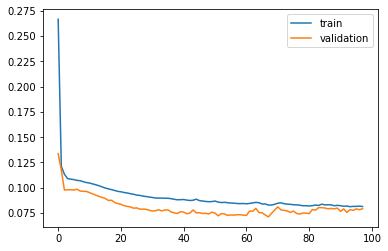

In [10]:
# fit network
history = model.fit(trainX, trainY, epochs = 200, batch_size = 10, validation_split = 0.2, verbose = 1, shuffle = False, callbacks = [earlystopper])
# shuffle = False siempre que sean timeseries, pues es una opción que, de ser activada, desordenará los datos aleatoriamente.
# callbacks = [earlystopper, checkpointer] activaría también la operación ModelCheckpoint.
# plot history
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.legend()
plt.show()

Se propone el entrenamiento de sendos modelos con dropout y bidirectional. Si bien el modelo que se planteó en un principio va a ser el que se emplee para el estudio, se proponen dos grandes cambios al modelo base que son el control del ratio de entrenamiento mediante dropout, y el empleo de capas de flujo bidireccional.

Los resultados respecto del dropout no supusieron una mejora para el modelo original. En el original el error de validación se reduce hasta 0'075, siendo así mejor que el de dropout. Además, hay una clara diferencia entre el error del train y del validation en favor de este último, con lo que es muy probable que se esté produciendo algo de underfitting en el train. Que estos resultados sean poco positivos, podría deberse a que el sistema es tan irregular, que reducir su efectividad sólo empeora la explicación mediante algoritmo de predicción.

Los resultados del bidirectional por otro lado, no se diferencian mucho del modelo convencional, también posiblemente por su irregularidad sin mucha explicación. Son claramente mejores que el que tenía dropouts. A parte de eso, muestra un overfitting del train en epochs más avanzados.

Epoch 1/200
31/31 [==============================] - 6s 26ms/step - loss: 0.2453 - accuracy: 0.0033 - val_loss: 0.1106 - val_accuracy: 0.0000e+00
Epoch 2/200
31/31 [==============================] - 0s 5ms/step - loss: 0.1087 - accuracy: 0.0033 - val_loss: 0.1096 - val_accuracy: 0.0000e+00
Epoch 3/200
31/31 [==============================] - 0s 5ms/step - loss: 0.1113 - accuracy: 0.0033 - val_loss: 0.0983 - val_accuracy: 0.0000e+00
Epoch 4/200
31/31 [==============================] - 0s 5ms/step - loss: 0.1111 - accuracy: 0.0033 - val_loss: 0.0999 - val_accuracy: 0.0000e+00
Epoch 5/200
31/31 [==============================] - 0s 5ms/step - loss: 0.1095 - accuracy: 0.0033 - val_loss: 0.0995 - val_accuracy: 0.0000e+00
Epoch 6/200
31/31 [==============================] - 0s 5ms/step - loss: 0.1087 - accuracy: 0.0033 - val_loss: 0.0992 - val_accuracy: 0.0000e+00
Epoch 7/200
31/31 [==============================] - 0s 5ms/step - loss: 0.1085 - accuracy: 0.0033 - val_loss: 0.1012 - val_accur

Epoch 6/200
31/31 [==============================] - 0s 5ms/step - loss: 0.1038 - accuracy: 0.0033 - val_loss: 0.0983 - val_accuracy: 0.0000e+00
Epoch 7/200
31/31 [==============================] - 0s 5ms/step - loss: 0.1025 - accuracy: 0.0033 - val_loss: 0.0969 - val_accuracy: 0.0000e+00
Epoch 8/200
31/31 [==============================] - 0s 5ms/step - loss: 0.1008 - accuracy: 0.0033 - val_loss: 0.0954 - val_accuracy: 0.0000e+00
Epoch 9/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0997 - accuracy: 0.0033 - val_loss: 0.0936 - val_accuracy: 0.0000e+00
Epoch 10/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0985 - accuracy: 0.0033 - val_loss: 0.0911 - val_accuracy: 0.0000e+00
Epoch 11/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0974 - accuracy: 0.0033 - val_loss: 0.0894 - val_accuracy: 0.0000e+00
Epoch 12/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0959 - accuracy: 0.0033 - val_loss: 0.0867 - val_acc

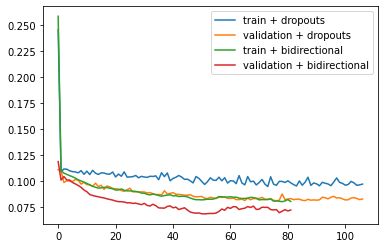

In [11]:
# fit de las redes modificadas
history_dropout = model_dropout.fit(trainX, trainY, epochs = 200, batch_size = 10, validation_split = 0.1, verbose = 1, shuffle = False, callbacks = [earlystopper])
history_bidirectional = model_bidirectional.fit(trainX, trainY, epochs = 200, batch_size = 10, validation_split = 0.1, verbose = 1, shuffle = False, callbacks = [earlystopper])
# plot history
plt.plot(history_dropout.history['loss'], label = 'train + dropouts')
plt.plot(history_dropout.history['val_loss'], label = 'validation + dropouts')
plt.plot(history_bidirectional.history['loss'], label = 'train + bidirectional')
plt.plot(history_bidirectional.history['val_loss'], label = 'validation + bidirectional')
plt.legend()
plt.show()

A continuación se va a realizar la predicción del mismo train y del test para comprobar el comportamiento del modelo creado a parte de la herramienta del error o loss. Los datos son tanto absorbidos como emitidos en el mismo formato normalizado de la red neuronal, por lo que para poder ser interpretados estos deben volver a tener sentido matematicamente.

Se invierte la escala y al comparar el error, el modelo es capaz de predecir los datos con los que ha sido entrenado (train) en comparación a los que no ha sido entrenado (test) de una manera coherente.

In [12]:
# Realiza la predicción.
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Teniendo ya la forma necesaria para ser representado y desescalado, se invierte la normalización y los datos se adaptan a un formato dimensionalmente similar a los datos originales para que pueda ser comparado.

In [13]:
# Se desnormalizan los datos para hacer que la predicción del train sea legible.
trainPredict_inv = scaler.inverse_transform(trainPredict)
trainPredict_inv = trainPredict_inv.reshape((len(trainPredict_inv)))
# Se desnormalizan los datos para hacer que la predicción del test sea legible.
testPredict_inv = scaler.inverse_transform(testPredict)
testPredict_inv = testPredict_inv.reshape((len(testPredict_inv)))

Para tener una visión inicial más clara de los errores, se readaptan los datos reales a un formato matemático coherente que pueda ser estadísticamente comparado con la predicción. De esto se pueden estraer los RMSE de la predicción respecto del train y del test.

In [14]:
# RMSE del train.
rmse = math.sqrt(mean_squared_error(train[:, -1], trainPredict_inv))
print('Train RMSE: %.3f' % rmse)
# RMSE del test.
rmse = math.sqrt(mean_squared_error(test[:, -1], testPredict_inv))
print('Test RMSE: %.3f' % rmse)

Train RMSE: 20257.214
Test RMSE: 22186.580


Estadísticos importantes para el caso normal, sin dropout ni bidireccional.

In [15]:
forecast_accuracy(test[:, -1], testPredict_inv)

D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 0.9999821,
 'me': -20231.695,
 'mae': 20231.695,
 'mpe': -0.9999821,
 'rmse': 22186.580448550427,
 'acf1': 0.09985797317758241,
 'corr': 0.6119570322798937,
 'minmax': 0.9999820000048203}

Ya que lo datos de la predicción han perdido su index original basado en fechas que se pueden representar de manera coherente, se debe emplear un eje nuevo de la X, en este caso basado en unidades. Se desplazan los datos predichos en el eje teniendo en cuenta que dicha predicción empieza tras el look_back. Además se tienen que desplazar los datos de predicción del test hasta despues del train.

In [16]:
# Se desplazan los datos del train para la representación.
trainPredictPlot = np.full((len(df)), np.nan)
trainPredictPlot[6:len(trainPredict_inv) + look_back] = trainPredict_inv
# Se desplazan los datos del test para la representación.
testPredictPlot = np.full((len(df)), np.nan)
testPredictPlot[len(trainPredict_inv) + look_back:len(df) + look_back] = testPredict_inv

Los datos se muestran mucho más cercanos a la realidad que los otros modelos empleados, pero hay que tener en cuenta que cada predicción se ha realizado en base a predictores reales. La idea sería que los datos sucesivos del futuro se obtengan empleando como predictores también variables predichas previamente.

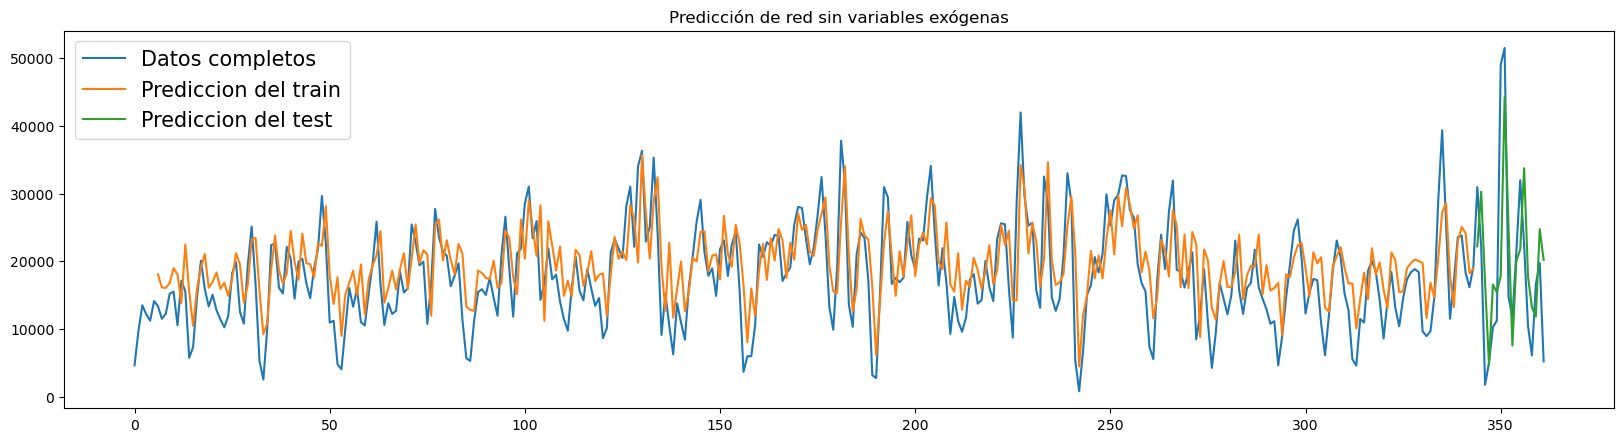

In [17]:
# Representación de las predicciones
plt.figure(figsize = (20, 5), dpi = 100)
plt.plot(df['cantidad'].values, label = 'Datos completos')
plt.plot(trainPredictPlot, label = 'Prediccion del train')
plt.plot(testPredictPlot, label = 'Prediccion del test')
plt.title('Predicción de red sin variables exógenas')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

# =============================================================

### Predicción del modelo mediante aprendizaje supervisado, añadiendo variables exógenas

El código a continuación pretende comprobar la validez de las variables exógenas propuestas en el notebook **estudio_datos**. El impacto del confinamiento por el SARS-CoV durante casi dos años y la asunción de la recuperación tras la crisis económica del 2008. Asumiendo que ambas variables tienen naturalezas distintas en su impacto respecto del modelo, se van a general dos variables exógenas a la tendencia. Una variable booleana 1, si se producía la crisis, 0 en caso contrario.

Primeramente se genera de nuevo el modelo, pero esta vez añadiendo las variables **crisis_demanda** (crisis del 2008) y **crisis_oferta** (COVID).

In [56]:
# los tres dataset
df_clientes = pd.read_csv(ROOT + "dClientes.csv", delimiter = ',')
df_dim_pedidos = pd.read_csv(ROOT + "dPedidos.csv", delimiter = ',')
df_pedidos = pd.read_csv(ROOT + "fPedidos.csv", delimiter = ',')
df_clientes = df_clientes.dropna()
df_dim_pedidos = df_dim_pedidos.dropna()
df_pedidos = df_pedidos.dropna()

# selecciona el id y la cantidad de pedidos en tabla auxiliar
df_aux = pd.DataFrame()
df_aux['cantidad'] = df_pedidos.groupby('digit_digit_sm_idpedido')['digit_digit_sm_cantidad'].sum()
df_aux = df_aux.reset_index() # groupby convierte la variable clave en index, por lo que hay que desconvertir

# crea un dataframe para unirlo todo
df = pd.DataFrame()
df['timestamp'] = pd.to_datetime(df_dim_pedidos['digit_digit_sm_fechapedido']) # extrae fechas
#df = df[df['timestamp'] > '2015-01-01'] # a partir del año del comportamiento actual
df = df[df['timestamp'] > '2012-01-01'] # a partir del año incluyendo la crisis del 2008
df['id_pedido'] = df_dim_pedidos['digit_digit_sm_idpedido'] # extrae id para añadir la informacion del pedido
df = df.join(df_aux.set_index('digit_digit_sm_idpedido'), on = 'id_pedido') # añade informacion de pedido
df = df.drop(['id_pedido'], axis = 1) # elimina la columna auxiliar de los pedidos
df = df.sort_values(by = 'timestamp', ascending = True) # ordena segun el timestamp
df['crisis_oferta'] = 0 # Se va a crear una columna de crisis de oferta para intentar reflejar el efecto del covid
df['crisis_oferta'].loc[(df['timestamp'] > '2020-03-14') & (df['timestamp'] < '2021-05-01')] = 1
df['crisis_demanda'] = 0 # Se va a crear una columna de crisis de demanda para intentar reflejar la crisis del 2008
df['crisis_demanda'].loc[(df['timestamp'] > '2012-01-01') & (df['timestamp'] < '2015-01-01')] = 1
df['week'] = df['timestamp'].dt.isocalendar().week # una columna con la semana del año
df['year'] = df['timestamp'].dt.year # una columna por año
df = df.set_index(['week', 'year']) # establece semanas y años de index para agrupar segun ellos
df['cantidad'] = df.groupby(['week', 'year'])['cantidad'].sum() # agrupa los pedidos que se produjeron la misma semana del año
df = df[~ df.index.duplicated(keep = 'first')] # elimina las replicas que se han producido en la agrupacion anterior
df = df.reset_index().set_index(['timestamp']) # cambia timestamp de index
df = df.drop(['week', 'year'], axis = 1) # elimina las columnas innecesarias
df['cantidad'] = df['cantidad'].rolling(1, center = True, closed = 'both').mean() # suavizado mediante Moving Average
# elimina nan
print(df.shape)
df = df.dropna()
print(df.shape)

# elimina negativos y ceros para poder aplicar seasonal
df = df[df['cantidad'] > 0]
df

(516, 3)
(516, 3)


D:\Python\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,cantidad,crisis_oferta,crisis_demanda
timestamp,,,
2012-01-02,3139.0,0,1
2012-01-10,3887.0,0,1
2012-01-16,3932.0,0,1
2012-01-23,4732.0,0,1
2012-01-30,7138.5,0,1
...,...,...,...
2021-11-01,10442.0,0,0
2021-11-10,6107.0,0,0
2021-12-01,16609.5,0,0


Como se vería la influencia de las variables exógenas en la serie de estudio;

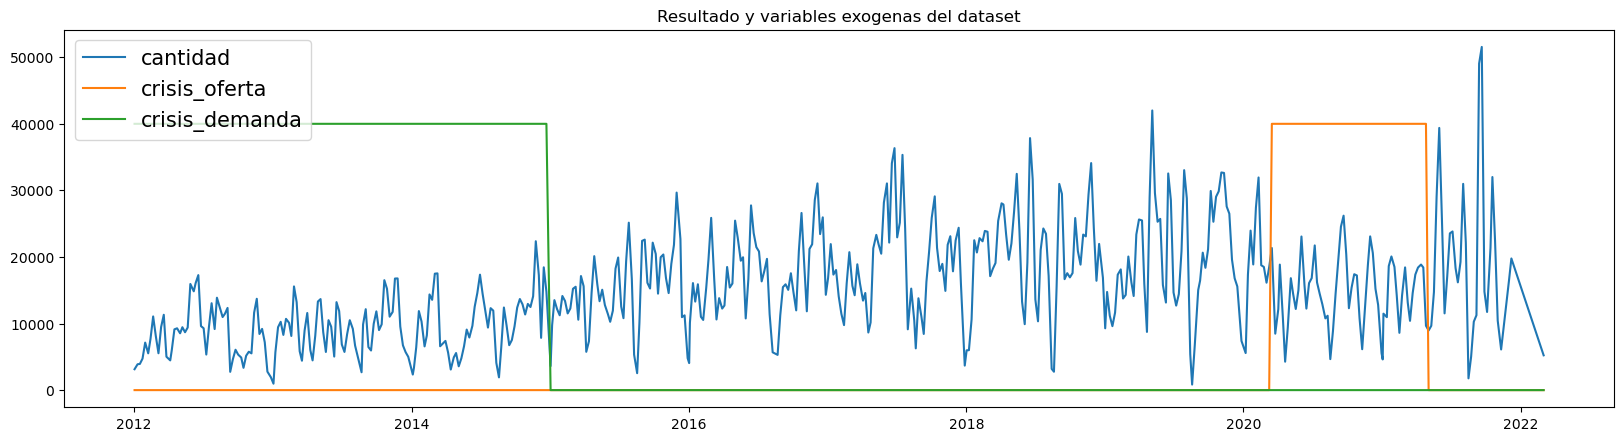

In [19]:
plt.figure(figsize = (20, 5), dpi = 100)
plt.plot(df['cantidad'], label = 'cantidad')
plt.plot(df['crisis_oferta'] * 40000, label = 'crisis_oferta')
plt.plot(df['crisis_demanda'] * 40000, label = 'crisis_demanda')
plt.title('Resultado y variables exogenas del dataset')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

Los datos pasados que serán empleados en la predicción, junto con la activación o no de las variables exógenas mediante una variable lógica.

**- Al programador que vaya a emplear este código para un estudio posterior. Nótese que cuando se tienen que emplear predictores por parte de capas recursivas, es necesario que estos predictores estén normalizados con valores entre 0 y 1. Las variables exógenas que aquí se emplean son lógicas con valores de 0 y 1, y por tanto, se pueden añadir posteriormente a dicha normalización. Si se deseasen emplear variables exógenas con números superiores, deberían ser normalizadas junto con los datos originales para poder ser empleadas por una red neuronal.**

In [20]:
look_back = 6

# Activar (exo = True) o desactivar (exo = False) las variables exógenas
exo = True

Igual que antes, los datos de trabajo deben convertirse en números del mismo tipo de variable y forma, por lo que además se tienen que normalizar ya que las LSTM y GRU emplean sigmoides, o sea, porcentajes entre 0 y 1.

In [21]:
values = df.values
# Garantiza que todos los datos estén en flotante.
values = values.astype('float32')
# Normalización de los datos para poder ser procesados por una red neuronal.
scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values[:, 0].reshape(len(values), 1)) # Se va a escalar únicamente los datos útiles.
# Creación de la matriz de lags previos como predictores.
reframed = series_to_supervised(scaled, n_in = look_back).values

Se le añaden las variables exógenas.

- Hay que aclarar que, al desplazamiento se le suma el look_back debido a que al desarrollar la matriz de los **n = look_back** valores previos, los primeros valores no iban a tener previos y por tanto se eliminan.

In [22]:
if (exo):
    reframed = np.append(values[look_back:, 1:], reframed, axis = 1)

De nuevo se deben separar los datos sin perder el orden en una lista de entrenamiento y otra de prueba, para posteriormente volver a separarlos en los dos dataset; los predictores X y los resultados Y teóricos que sirven para el entrenamiento.
- Cabe destacar que la red neuronal en este caso necesita un formato de tres dimensiones para poder integrar todos los datos de estudio, por lo que se tiene que realizar el reshape.

In [23]:
# Divide los datos en train y test.
train, test = divide(reframed, proporcion = 0.95)
# Separa el dataset entre datos de predicción X y datos reales Y.
trainX, trainY = train[:, :-1], train[:, -1]
testX, testY = test[:, :-1], test[:, -1]
# Cambio a formato ideal (3D) para la red neuronal.
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(484, 1, 8) (484,)
(26, 1, 8) (26,)


De nuevo se construye el modelo definido por la función previamente declarada.

In [24]:
model = creador_de_modelos(trainX, loss = 'mae', fast = True)

Se entrena el modelo y de hecho, el performance acaba presentando un error en la validación menor que el modelo con únicamente una serie temporal autodefinitoria, bajando del 0.1, mientras que en el caso anterior acababa siendo menor a 0'08, en este caso se alcanza esa cifra pero es más coherente y constante en su error.

Epoch 1/200
7/7 [==============================] - 6s 101ms/step - loss: 0.2720 - accuracy: 0.0023 - val_loss: 0.2599 - val_accuracy: 0.0000e+00
Epoch 2/200
7/7 [==============================] - 0s 8ms/step - loss: 0.2400 - accuracy: 0.0023 - val_loss: 0.2247 - val_accuracy: 0.0000e+00
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 0.2042 - accuracy: 0.0023 - val_loss: 0.1856 - val_accuracy: 0.0000e+00
Epoch 4/200
7/7 [==============================] - 0s 8ms/step - loss: 0.1678 - accuracy: 0.0023 - val_loss: 0.1462 - val_accuracy: 0.0000e+00
Epoch 5/200
7/7 [==============================] - 0s 7ms/step - loss: 0.1356 - accuracy: 0.0023 - val_loss: 0.1140 - val_accuracy: 0.0000e+00
Epoch 6/200
7/7 [==============================] - 0s 8ms/step - loss: 0.1138 - accuracy: 0.0023 - val_loss: 0.1001 - val_accuracy: 0.0000e+00
Epoch 7/200
7/7 [==============================] - 0s 7ms/step - loss: 0.1065 - accuracy: 0.0023 - val_loss: 0.0979 - val_accuracy: 0.0000e+

Epoch 58/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0808 - accuracy: 0.0023 - val_loss: 0.0915 - val_accuracy: 0.0000e+00
Epoch 59/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0803 - accuracy: 0.0023 - val_loss: 0.0920 - val_accuracy: 0.0000e+00
Epoch 60/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0801 - accuracy: 0.0023 - val_loss: 0.0907 - val_accuracy: 0.0000e+00
Epoch 61/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0797 - accuracy: 0.0023 - val_loss: 0.0909 - val_accuracy: 0.0000e+00
Epoch 62/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0794 - accuracy: 0.0023 - val_loss: 0.0896 - val_accuracy: 0.0000e+00
Epoch 63/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0792 - accuracy: 0.0023 - val_loss: 0.0889 - val_accuracy: 0.0000e+00
Epoch 64/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0786 - accuracy: 0.0023 - val_loss: 0.0891 - val_accuracy: 0.0

Epoch 115/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0691 - accuracy: 0.0023 - val_loss: 0.0776 - val_accuracy: 0.0000e+00
Epoch 116/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0687 - accuracy: 0.0023 - val_loss: 0.0773 - val_accuracy: 0.0000e+00
Epoch 117/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0689 - accuracy: 0.0023 - val_loss: 0.0776 - val_accuracy: 0.0000e+00
Epoch 118/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0686 - accuracy: 0.0023 - val_loss: 0.0775 - val_accuracy: 0.0000e+00
Epoch 119/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0688 - accuracy: 0.0023 - val_loss: 0.0775 - val_accuracy: 0.0000e+00
Epoch 120/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0685 - accuracy: 0.0023 - val_loss: 0.0772 - val_accuracy: 0.0000e+00
Epoch 121/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0686 - accuracy: 0.0023 - val_loss: 0.0774 - val_accura

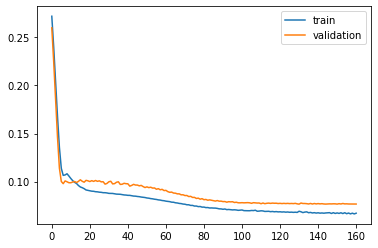

In [25]:
earlystopper = EarlyStopping(patience = 30, verbose = 1)
# fit network
history = model.fit(trainX, trainY, epochs = 200, batch_size = 72, validation_split = 0.1, verbose = 1, shuffle = False, callbacks = [earlystopper])
# plot history
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.legend()
plt.show()

Se realiza el mismo proceso de des-transformación de los datos que se realizó en el ejercicio previo, en este caso resumido y compacto.

In [26]:
# RMSE del train.
# Se desnormalizan los datos para hacer que la predicción del train sea legible.
trainPredict_inv = scaler.inverse_transform(model.predict(trainX))
trainPredict_inv = trainPredict_inv.reshape((len(trainPredict_inv)))
rmse = math.sqrt(mean_squared_error(train[:, -1], trainPredict_inv))
print('Train RMSE: %.3f' % rmse)

# RMSE del test.
# Se desnormalizan los datos para hacer que la predicción del test sea legible.
testPredict_inv = scaler.inverse_transform(model.predict(testX))
testPredict_inv = testPredict_inv.reshape((len(testPredict_inv)))
rmse = math.sqrt(mean_squared_error(test[:, -1], testPredict_inv))
print('Test RMSE: %.3f' % rmse)

Train RMSE: 15485.718
Test RMSE: 20035.660


Estadísticos importantes.

In [27]:
forecast_accuracy(test[:, -1], testPredict_inv)

D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 0.9999803,
 'me': -18715.277,
 'mae': 18715.277,
 'mpe': -0.9999803,
 'rmse': 20035.66020873782,
 'acf1': 0.04193057658229349,
 'corr': 0.5747202719353314,
 'minmax': 0.9999802478796482}

Se desplazan los datos y las predicciones de manera que encajen en su posición respectiva en la representación gráfica y se plasman estos valores en la gráfica final.

- Hay que aclarar que, al desplazamiento se le suma el look_back debido a que al desarrollar la matriz de los **n = look_back** valores previos, los primeros valores no iban a tener previos y por tanto se eliminan. 

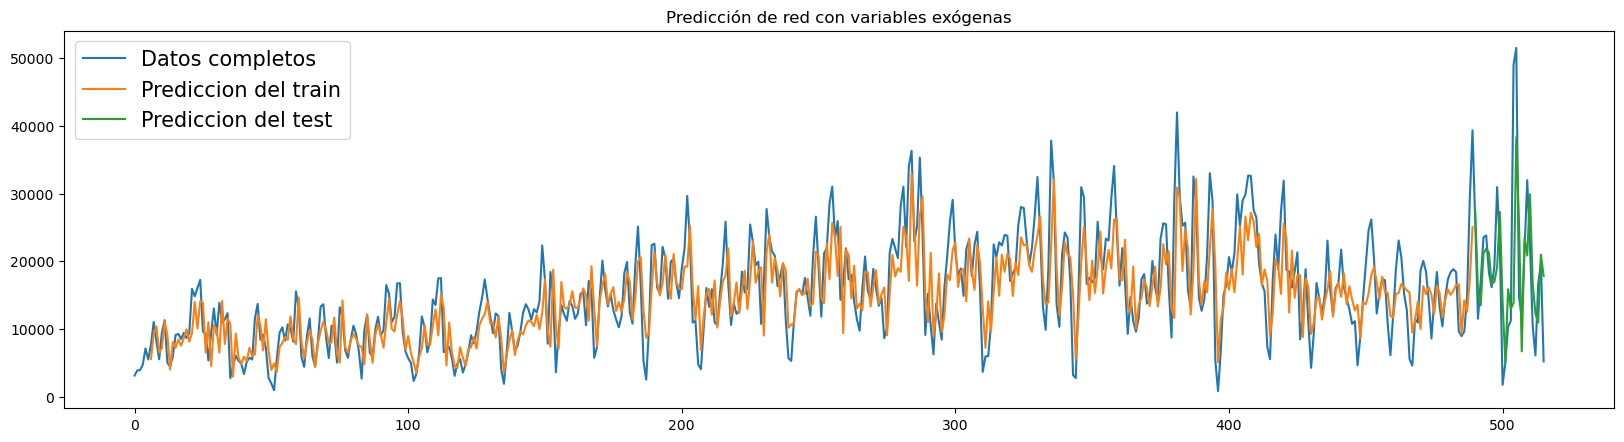

In [28]:
# Se desplazan los datos del train para la representación.
trainPredictPlot = np.full((len(df)), np.nan)
trainPredictPlot[6:len(trainPredict_inv) + look_back] = trainPredict_inv
# Se desplazan los datos del test para la representación.
testPredictPlot_exo = np.full((len(df)), np.nan)
testPredictPlot_exo[len(trainPredict_inv) + look_back:len(df) + look_back] = testPredict_inv

# Representación de las predicciones
plt.figure(figsize = (20, 5), dpi = 100)
plt.plot(df['cantidad'].values, label = 'Datos completos')
plt.plot(trainPredictPlot, label = 'Prediccion del train')
plt.plot(testPredictPlot_exo, label = 'Prediccion del test')
plt.title('Predicción de red con variables exógenas')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

### Código extra

Código para exportar modelos:

In [29]:
# Serializa el modelo en JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Almacenar los pesos en HDF5
model.save_weights("model.h5")
print("Modelo guardado...")

Modelo guardado...


**- Código auxiliar preparado para poder cargar modelos desde fuera;**

# =============================================================

### Predicción de algunas semanas en el futuro mediante modelo estático

In [30]:
# los tres dataset
df_clientes = pd.read_csv(ROOT + "dClientes.csv", delimiter = ',')
df_dim_pedidos = pd.read_csv(ROOT + "dPedidos.csv", delimiter = ',')
df_pedidos = pd.read_csv(ROOT + "fPedidos.csv", delimiter = ',')
df_clientes = df_clientes.dropna()
df_dim_pedidos = df_dim_pedidos.dropna()
df_pedidos = df_pedidos.dropna()

# selecciona el id y la cantidad de pedidos en tabla auxiliar
df_aux = pd.DataFrame()
df_aux['cantidad'] = df_pedidos.groupby('digit_digit_sm_idpedido')['digit_digit_sm_cantidad'].sum()
df_aux = df_aux.reset_index() # groupby convierte la variable clave en index, por lo que hay que desconvertir

# crea un dataframe para unirlo todo
df = pd.DataFrame()
df['timestamp'] = pd.to_datetime(df_dim_pedidos['digit_digit_sm_fechapedido']) # extrae fechas
df = df[df['timestamp'] > '2015-01-01'] # a partir del año del comportamiento actual
#df = df[df['timestamp'] > '2012-01-01'] # a partir del año incluyendo la crisis del 2008
#df = df[df['timestamp'] < '2021-06-01'] # omitiendo los picos de ventas post-covid
df['id_pedido'] = df_dim_pedidos['digit_digit_sm_idpedido'] # extrae id para añadir la informacion del pedido
df = df.join(df_aux.set_index('digit_digit_sm_idpedido'), on = 'id_pedido') # añade informacion de pedido
df = df.drop(['id_pedido'], axis = 1) # elimina la columna auxiliar de los pedidos
df = df.sort_values(by = 'timestamp', ascending = True) # ordena segun el timestamp
df['week'] = df['timestamp'].dt.isocalendar().week # una columna con la semana del año
df['year'] = df['timestamp'].dt.year # una columna por año
df = df.set_index(['week', 'year']) # establece semanas y años de index para agrupar segun ellos
df['cantidad'] = df.groupby(['week', 'year'])['cantidad'].sum() # agrupa los pedidos que se produjeron la misma semana del año
df = df[~ df.index.duplicated(keep = 'first')] # elimina las replicas que se han producido en la agrupacion anterior
df = df.reset_index().set_index(['timestamp']) # cambia timestamp de index
df = df.drop(['week', 'year'], axis = 1) # elimina las columnas innecesarias
df['cantidad'] = df['cantidad'].rolling(1, center = True, closed = 'both').mean() # suavizado mediante Moving Average
# elimina nan
print(df.shape)
df = df.dropna()
print(df.shape)

# elimina negativos y ceros para poder aplicar seasonal
df = df[df['cantidad'] > 0]
df

(362, 1)
(362, 1)


,cantidad
timestamp,
2015-01-02,4665.0
2015-01-06,9749.0
2015-01-12,13518.0
2015-01-19,12178.5
2015-01-26,11241.5
...,...
2021-11-01,10442.0
2021-11-10,6107.0
2021-12-01,16609.5


In [31]:
look_back = 6

Epoch 1/200
27/27 [==============================] - 3s 26ms/step - loss: 0.2618 - accuracy: 0.0037 - val_loss: 0.1277 - val_accuracy: 0.0000e+00
Epoch 2/200
27/27 [==============================] - 0s 4ms/step - loss: 0.1186 - accuracy: 0.0037 - val_loss: 0.1165 - val_accuracy: 0.0000e+00
Epoch 3/200
27/27 [==============================] - 0s 3ms/step - loss: 0.1136 - accuracy: 0.0037 - val_loss: 0.0976 - val_accuracy: 0.0000e+00
Epoch 4/200
27/27 [==============================] - 0s 3ms/step - loss: 0.1097 - accuracy: 0.0037 - val_loss: 0.0982 - val_accuracy: 0.0000e+00
Epoch 5/200
27/27 [==============================] - 0s 3ms/step - loss: 0.1091 - accuracy: 0.0037 - val_loss: 0.0990 - val_accuracy: 0.0000e+00
Epoch 6/200
27/27 [==============================] - 0s 4ms/step - loss: 0.1089 - accuracy: 0.0037 - val_loss: 0.0986 - val_accuracy: 0.0000e+00
Epoch 7/200
27/27 [==============================] - 0s 3ms/step - loss: 0.1085 - accuracy: 0.0037 - val_loss: 0.0982 - val_accur

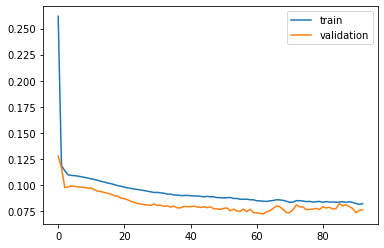

In [32]:
values = df.values
# Garantiza que todos los datos estén en flotante.
values = values.astype('float32')
# Normalización de los datos para poder ser procesados por una red neuronal.
scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values[:, 0].reshape(len(values), 1)) # Se va a escalar únicamente los datos útiles.
# Creación de la matriz de lags previos como predictores.
reframed = series_to_supervised(scaled, n_in = look_back).values
# Divide los datos en train y test.
train, test = divide(reframed, proporcion = 0.95)
# Separa el dataset entre datos de predicción X y datos reales Y.
trainX, trainY = train[:, :-1], train[:, -1]
testX, testY = test[:, :-1], test[:, -1]
# Cambio a formato ideal (3D) para la red neuronal.
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
# Se declaran las capas de la red.
model = creador_de_modelos(trainX, loss = 'mae', fast = True)
earlystopper = EarlyStopping(patience = 30, verbose = 1) # Si en "patience" epochs no mejora, se cierra el bucle de epochs.
# fit network
history = model.fit(trainX, trainY, epochs = 200, batch_size = 10, validation_split = 0.2, verbose = 1, shuffle = False, callbacks = [earlystopper])
# plot history
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.legend()
plt.show()

In [33]:
forecast_list = np.reshape(scaled[-look_back - 1: -1], look_back)
# Por como funciona el sistema de lectura y reescritura, se necesita invertir el vector de predicciones inicial.
forecast_list = np.flip(forecast_list, 0)

In [34]:
for i in range(len(test)):
    # Cuando se realiza el append, la dimension pasa a ser 1, hay que devolverle las 3D.
    prediction = model.predict(np.asarray(forecast_list[-look_back:].reshape(1, 1, look_back))) # La predicción debe realizarse con tres dimensiones siempre.
    forecast_list = np.append(forecast_list, prediction)

In [35]:
# La desnormalización requiere de datos en un formato determinado.
forecast_list = np.reshape(forecast_list, (len(forecast_list), 1))
# Se desnormalizan los datos para hacer que la predicción del test sea legible.
testPredict_inv = scaler.inverse_transform(forecast_list)
testPredict_inv = testPredict_inv.reshape((len(testPredict_inv)))
# Se eliminan los 6 primeros valores que se emplearon en realizar la primera predicción.
testPredict_inv = testPredict_inv[6:]

In [36]:
# RMSE del test.
rmse = math.sqrt(mean_squared_error(test[:, -1], testPredict_inv))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 22664.060


In [37]:
forecast_accuracy(test[:, -1], testPredict_inv)

D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 0.9999843,
 'me': -22626.69,
 'mae': 22626.69,
 'mpe': -0.9999843,
 'rmse': 22664.060006980213,
 'acf1': -0.007009307622944839,
 'corr': 0.3624122689473483,
 'minmax': 0.9999843344885448}

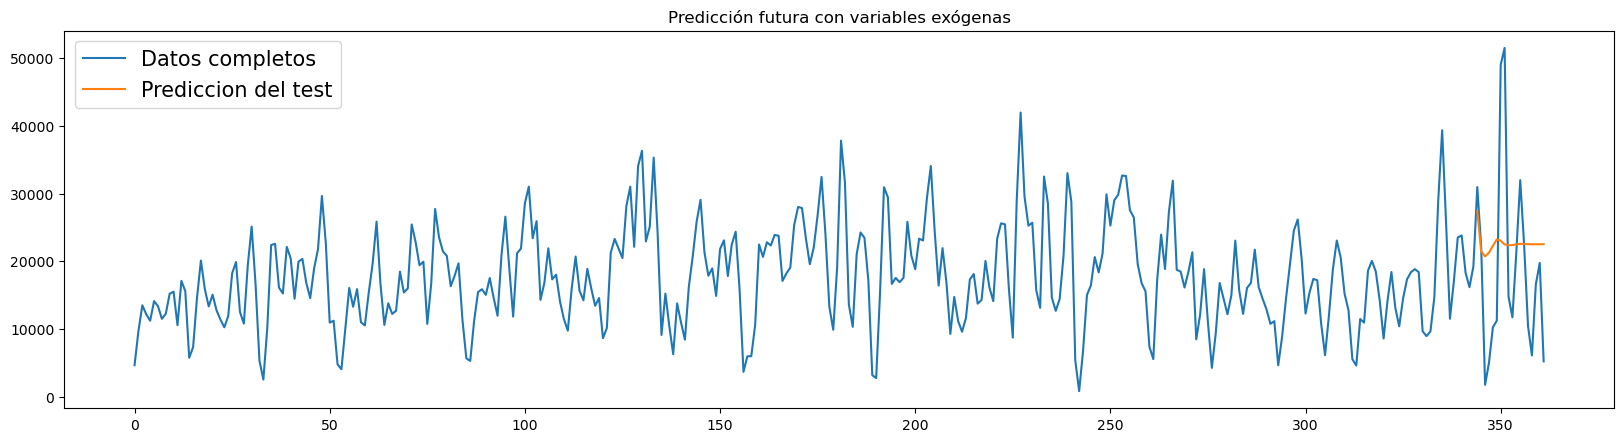

In [38]:
# Se desplazan los datos del test para la representación.
testPredictPlot_futuro = np.full((len(df)), np.nan)
testPredictPlot_futuro[len(train) + look_back:len(df)] = testPredict_inv

# Representación de las predicciones
plt.figure(figsize = (20, 5), dpi = 100)
plt.plot(df['cantidad'].values, label = 'Datos completos')
plt.plot(testPredictPlot_futuro, label = 'Prediccion del test')
plt.title('Predicción futura con variables exógenas')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

# =============================================================

### Comparación final

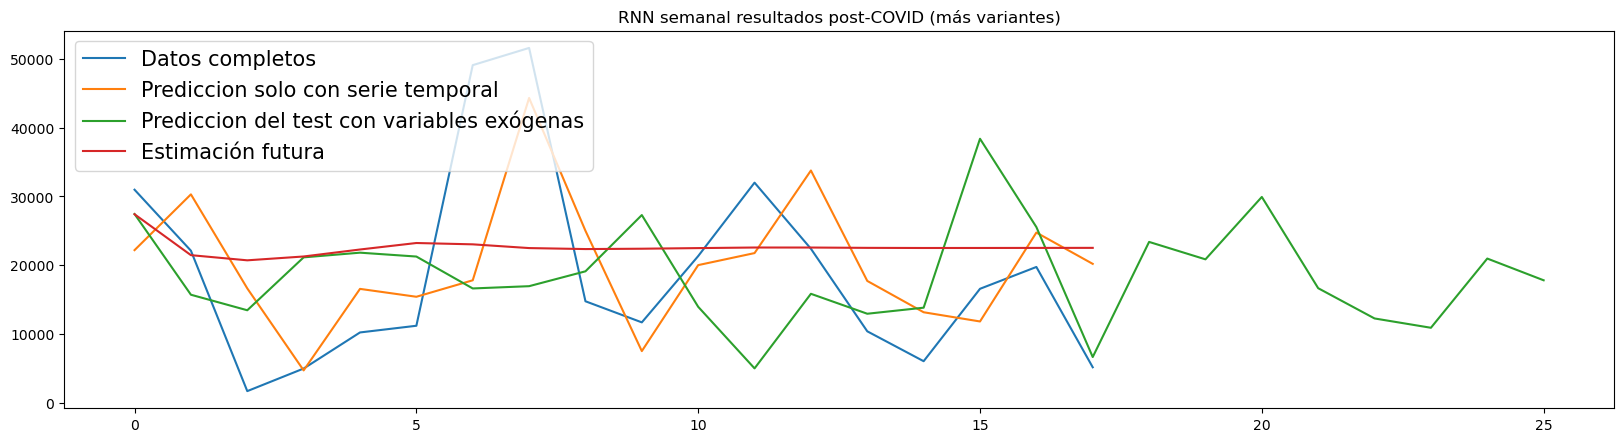

In [89]:
# Ajustando el eje X para que se vean mejor todas las mediciones.
train, test = divide(values, proporcion = 0.95)

# Se tienen que desplazar los valores ya que hay mas por incluir los años previos a 2015.
testPredictPlot_ajustado = testPredictPlot[~np.isnan(testPredictPlot)]
testPredictPlot_exo_ajustado = testPredictPlot_exo[~np.isnan(testPredictPlot_exo)]
testPredictPlot_futuro_ajustado = testPredictPlot_futuro[~np.isnan(testPredictPlot_futuro)]

# Representación de las predicciones
plt.figure(figsize = (20, 5), dpi = 100)
plt.plot(test, label = 'Datos completos')
plt.plot(testPredictPlot_ajustado, label = 'Prediccion solo con serie temporal')
plt.plot(testPredictPlot_exo_ajustado, label = 'Prediccion del test con variables exógenas')
plt.plot(testPredictPlot_futuro_ajustado, label = 'Estimación futura')
plt.title('RNN semanal resultados post-COVID (más variantes)')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()